# Part 2: Wenzinger's test case

In [1]:
#Importing the libraries and modules we need.
import numpy
import math
from scipy import integrate, linalg
from matplotlib import pyplot
#The next line allows as to plot directly in the notebook.
%matplotlib inline

In [2]:
# loading the geometry from a data file
x_naca, y_naca = numpy.loadtxt('NACA23012_MainFoil.csv', dtype=float, delimiter=',', unpack=True)
x_naca_flap, y_naca_flap = numpy.loadtxt('NACA23012_FlapFoil.csv',dtype=float, delimiter=',', unpack=True)

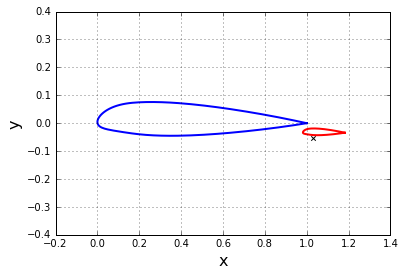

In [3]:
# plots the geometry

pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.xlim(-0.2, 1.4)
pyplot.ylim(-0.4, 0.4)

x_h, y_h = 1.03, -0.054 #hinge

pyplot.plot(x_naca, y_naca, color='b', linestyle='-', linewidth=2)
pyplot.plot(x_naca_flap, y_naca_flap, color='r', linestyle='-', linewidth=2)
pyplot.scatter(x_h, y_h, color='k', marker='x');

In [4]:
def rotate(x,y,cx,cy, alpha):
    """
    x,y : coordinates I want to rotate
    cx, cy : point around I want to rotate
    alpha: how many degrees I want to rotate 
    """
    
    r = numpy.sqrt((x-cx)**2 + (y-cy)**2)
    theta_initial = numpy.arccos((x-cx)/r)
    theta_new = theta_initial - alpha/180.*numpy.pi
    
    x_rot = r*numpy.cos(theta_new) + cx
    y_rot = r*numpy.sin(theta_new) + cy
    
    return x_rot, y_rot

In [5]:
alpha = 10. 
x_rot, y_rot = rotate(x_naca_flap, y_naca_flap, x_h, y_h, alpha)

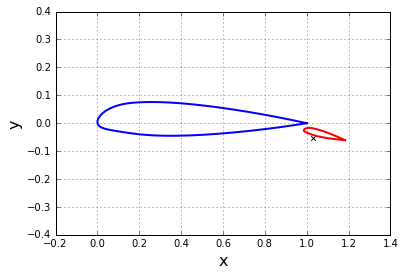

In [6]:
# plots the geometry

pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.xlim(-0.2, 1.4)
pyplot.ylim(-0.4, 0.4)

pyplot.plot(x_naca, y_naca, color='b', linestyle='-', linewidth=2)
pyplot.plot(x_rot, y_rot, color='r', linestyle='-', linewidth=2)
pyplot.scatter(x_h, y_h, color='k', marker='x');

In [7]:
class Panel:
    """
    Contains information related to a panel.
    """
    def __init__(self, xa, ya, xb, yb):
        """
        Initializes the panel.
        
        Sets the end-points and calculates the center, length,
        and angle (with the x-axis) of the panel.
        Defines if the panel is on the lower or upper surface of the geometry.
        Initializes the source-sheet strength, tangential velocity,
        and pressure coefficient to zero.
        
        Parameters
        ----------
        xa: float
            x-coordinate of the first end-point.
        ya: float
            y-coordinate of the first end-point.
        xb: float
            x-coordinate of the second end-point.
        yb: float
            y-coordinate of the second end-point.
        """
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2       # control-point (center-point)
        self.length = math.sqrt((xb-xa)**2+(yb-ya)**2)     # length of the panel
        
        # orientation of the panel (angle between x-axis and panel's normal)
        if xb-xa <= 0.:
            self.beta = math.acos((yb-ya)/self.length)
        elif xb-xa > 0.:
            self.beta = math.pi + math.acos(-(yb-ya)/self.length)
        
        # location of the panel
        if self.beta <= math.pi:
            self.loc = 'upper'
        else:
            self.loc = 'lower'
        
        self.sigma = 0.                             # source strength
        self.vt = 0.                                # tangential velocity
        self.cp = 0.         

In [8]:
def define_panels(x, y, N):
    x, y = numpy.append(x, x[0]), numpy.append(y, y[0])    # extend arrays using numpy.append
    panels = numpy.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x[i], y[i], x[i+1], y[i+1])
    
    return panels

In [9]:
class Freestream:
    """
    Freestream conditions.
    """
    def __init__(self, U_inf, alpha=0.0):
        """
        Sets the freestream speed and angle (with the x-axis).
        
        Parameters
        ----------
        u_inf: float, optional
            Freestream speed;
            default: 1.0.
        alpha: float, optional
            Angle of attack in degrees;
            default: 0.0.
        """
        self.U_inf = U_inf
        self.alpha = alpha*math.pi/180          # degrees --> radians

In [10]:
def integral(x, y, panel, dxdk, dydk):
    """
    Evaluates the contribution from a panel at a given point.
    
    Parameters
    ----------
    x: float
        x-coordinate of the target point.
    y: float
        y-coordinate of the target point.
    panel: Panel object
        Panel whose contribution is evaluated.
    dxdk: float
        Value of the derivative of x in a certain direction.
    dydk: float
        Value of the derivative of y in a certain direction.
    
    Returns
    -------
    Contribution from the panel at a given point (x, y).
    """
    def integrand(s):
        return ( ((x - (panel.xa - numpy.sin(panel.beta)*s))*dxdk
                  +(y - (panel.ya + numpy.cos(panel.beta)*s))*dydk)
                / ((x - (panel.xa - numpy.sin(panel.beta)*s))**2
                   +(y - (panel.ya + numpy.cos(panel.beta)*s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

def source_matrix_normal(panels):
    """Builds the source matrix.
    
    Arguments
    ---------
    panels: array of panels.
    
    Returns
    -------
    A_n: NxN matrix (N is the number of panels).
    """
    N = len(panels)
    A_n = numpy.empty((N, N), dtype=float)
    numpy.fill_diagonal(A_n, 0.5)
    
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i != j:
                A_n[i,j] = 0.5/numpy.pi*integral(p_i.xc, p_i.yc, p_j, numpy.cos(p_i.beta), numpy.sin(p_i.beta))
                
    return A_n

def vortex_matrix_normal(panels):
    """Builds the vortex matrix.
    
    Arguments
    ---------
    panels: array of panels.
    
    Returns
    -------
    B_n: NxN matrix (N is the number of panels).
    s_bn: 1D array (Nx1, N is the number of panels) 
         (is the sum over j of the coefficients ).
    """
    N = len(panels)
    B_n = numpy.empty((N, N), dtype=float)
    numpy.fill_diagonal(B_n, 0.)
    
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i != j:
                B_n[i,j] = -0.5/numpy.pi*integral(p_i.xc, p_i.yc, p_j, numpy.sin(p_i.beta), -numpy.cos(p_i.beta))
                
    return B_n

def vortex_arrays_normal(panels, B_n):
    """Builds the vortex array for normal matrix.
    
    Arguments
    ---------
    panels: array of panels.
    B_n: NxN matrix (N is the number of panels). Vortex normal matrix
    Returns
    -------
    a -- 1D array (Nx1, N is the number of panels).
    """
    N = len(panels)
    a1_n = numpy.zeros(panels.size, dtype=float)
    a2_n = numpy.zeros(panels.size, dtype=float)
    for i, p_i in enumerate(panels):
        
            a1_n[i] = numpy.sum(B_n[i,0:N/2]) 
            a2_n[i] = numpy.sum(B_n[i,N/2:])
    
    return a1_n , a2_n

def A_normal(A_n, a1_n , a2_n, N):
    """Builds the normal matrix.
    
    Arguments
    ---------
    panels: array of panels.
    A_n: NxN matrix (N is the number of panels). Vortex normal matrix
    a1_n -- 1D array (Nx1, N is the number of panels).
    a2_n -- 1D array (Nx1, N is the number of panels).
    Returns
    -------
    A_normal: Nx(N+2) matrix (N is the number of panels).
    """

    #Matrix A_normal (Nx(N+2))

    A_normal = numpy.empty((N, N+2), dtype=float)

    A_normal[0:N,0:N] = A_n[:,:]
    A_normal[0:N,-2] = a1_n[:]
    A_normal[0:N,-1] = a2_n[:]
    
    return A_normal

def vortex_arrays_tangential(panels, A_n):
    """Builds the vortex array for normal matrix.
    
    Arguments
    ---------
    panels: array of panels.
    A_n: NxN matrix (N is the number of panels). Source normal matrix
    Returns
    -------
    a1_t -- 1D array (Nx1, N is the number of panels).
    a2_t -- 1D array (Nx1, N is the number of panels).
    """
    N = len(panels)
    a1_t = numpy.zeros(panels.size, dtype=float)
    a2_t = numpy.zeros(panels.size, dtype=float)
    for i, p_i in enumerate(panels):
        
            a1_t[i] = numpy.sum(A_n[i,0:N/2]) 
            a2_t[i] = numpy.sum(A_n[i,N/2:])
    
    return a1_t , a2_t

def A_tangential(B_n, a1_t , a2_t, N):
    """Builds the tangential matrix.
    
    Arguments
    ---------
    panels: array of panels.
    B_n: NxN matrix (N is the number of panels). Vortex normal matrix
    
    Returns
    -------
    A_tangential: Nx(N+2) matrix (N is the number of panels).
    """

    #Matrix A_tangential (Nx(N+2))

    A_tangential = numpy.empty((N, N+2), dtype=float)

    A_tangential[0:N,0:N] = B_n[:,:]
    A_tangential[0:N,-2] = -a1_t[:]
    A_tangential[0:N,-1] = -a2_t[:]
    
    return A_tangential

#Kutta arrays

def kutta_arrays(A_tangential, N):
    """Builds the kutta arrays.
    
    Arguments
    ---------
    A_tangential: Nx(N+2) matrix (N is the number of panels).
    
    Returns
    -------
    k_a1 -- 1D array ((N+2)x1, N is the number of panels). kutta array 1
    k_a2 -- 1D array ((N+2)x1, N is the number of panels). kutta array 2
    """
    k_a1 = numpy.zeros(N+2,dtype=float)
    k_a2 = numpy.zeros(N+2,dtype=float)

    k_a1 = A_tangential[0,:] + A_tangential[N/2-1,:]
    k_a2 = A_tangential[N/2,:] + A_tangential[N-1,:]
    
    return k_a1, k_a2

def build_matrix(panels, A_normal, k_a1, k_a2):
    """Builds the matrix of the linear system.
    
    Arguments
    ---------
    panels: array of panels.
    A_n: matrix normal
    k_a1: Kutta array 1
    k_a2: Kutta array 2
    
    Returns
    -------
    A -- (N+2)x(N+2) matrix (N is the number of panels).
    """
    N = len(panels)
    A = numpy.empty((N+2, N+2), dtype=float)
    
    A[0:N,:] = A_normal[:,:]
    A[-2,:] = k_a1[:]
    A[-1,:] = k_a2[:]
    
    return A

def build_rhs(panels, freestream):
    """Builds the RHS of the linear system.
    
    Arguments
    ---------
    panels: array of panels.
    freestream: farfield conditions.
    
    Returns
    -------
    b: 1D array ((N+2)x1, N is the number of panels).
    """
    N = len(panels)
    b = numpy.empty(N+2,dtype=float)
    
    for i, panel in enumerate(panels):
        b[i] = -freestream.U_inf * numpy.cos(freestream.alpha - panel.beta)
    b[N] = -freestream.U_inf*( numpy.sin(freestream.alpha-panels[0].beta)
                              +numpy.sin(freestream.alpha-panels[N/2-1].beta) )
    b[N+1] = -freestream.U_inf*( numpy.sin(freestream.alpha-panels[N/2].beta)
                              +numpy.sin(freestream.alpha-panels[N-1].beta) )
    return b

def get_tangential_velocity(panels, freestream, gamma1, gamma2, A_tangential):
    """Computes the tangential velocity on the surface.
    
    Arguments
    ---------
    panels -- array of panels.
    freestream -- farfield conditions.
    gamma1 -- circulation density of airfoil.
    gamma2 -- circulation density of flap.
    
    """
    N = len(panels)

    b = freestream.U_inf * numpy.sin([freestream.alpha - panel.beta for panel in panels])
    
    var1 = numpy.append([panel.sigma for panel in panels], gamma1)
    var = numpy.append(var1, gamma2)
    
    vt = numpy.dot(A_tangential, var) + b
    for i, panel in enumerate(panels):
        panel.vt = vt[i]

In [11]:
def get_pressure_coefficient(panels, freestream):
    """Computes the surface pressure coefficients.
    
    Arguments
    ---------
    panels -- array of panels.
    freestream -- farfield conditions.
    """
    for panel in panels:
        panel.cp = 1.0 - (panel.vt/freestream.U_inf)**2

In [12]:
def get_coefficients(panels):
    L = 0.
    D = 0.
    for panel in panels:
        L -= panel.cp*panel.length*numpy.sin(panel.beta)
        D += panel.cp*panel.length*numpy.cos(panel.beta)
    return L, D

In [13]:
def get_lift(aoa,aof):
    """
    """
    #hinge
    x_h, y_h = 1.03, -0.054
    
    #Rotate the flap
    x_rot, y_rot = rotate(x_naca_flap, y_naca_flap, x_h, y_h, aof)
    
    # define freestream conditions 
    
    freestream = Freestream(1, aoa)
    
    #Generate panels 
    
    Np=len(x_naca)-1
    
    panels_airfoil = define_panels(x_naca, y_naca, Np)   # discretizes of the airfoil into panels

    panels_flap = define_panels(x_rot, y_rot, Np )   # discretizes of the flap into panels

    #Put all the panels together
    
    panels = numpy.concatenate((panels_airfoil, panels_flap))
    
    N = 2*Np #Redifining N, so when we do slices in N we are talking about N=N_airfoil+N_flap

    # Parts of matrix A_normal
    A_n = source_matrix_normal(panels)
    
    B_n = vortex_matrix_normal(panels)
    a1_n , a2_n = vortex_arrays_normal(panels, B_n)
    
    #Building A_normal
    A_norm = A_normal(A_n, a1_n , a2_n, N)
    
    #Parts of A_tangential
    a1_t , a2_t = vortex_arrays_normal(panels, A_n)
    
    #Building A_tangential
    A_tan = A_tangential(B_n, a1_t , a2_t, N)

    #Kutta array
    k_a1, k_a2 = kutta_arrays(A_tan, N)
    
    #Building the linear system to solve the strength
    
    A = build_matrix(panels, A_norm, k_a1, k_a2)                 # calculates the singularity matrix
    b = build_rhs(panels, freestream)         # calculates the freestream RHS
    
    # solves the linear system
    variables = linalg.solve(A, b)

    for i, panel in enumerate(panels):
        panel.sigma = variables[i]
    gamma1 = variables[-2]
    gamma2 = variables[-1]

    #Get the tangential velocity
    get_tangential_velocity(panels, freestream, gamma1, gamma2, A_tan)

    #computes surface pressure coefficient
    get_pressure_coefficient(panels,freestream)    

    #Get coefficients of Lift and Drag
    L, D = get_coefficients(panels)

    return L

In [14]:
def bisection(a, b, aof, tol):
    
    
    L_a = get_lift(a, aof)
    L_b = get_lift(b, aof)
        
    if numpy.sign(L_a) != numpy.sign(L_b):
        aoa_c = (a+b)/2.
        L_c = get_lift(aoa_c, aof)
    
   
        if numpy.abs(L_c) < tol:
            print ('The required angle of attack is')
            print (aoa_c)
        
        else:
            print ('please wait')
            
            if numpy.sign(L_c) == numpy.sign(L_a):
                bisection(aoa_c, b, aof, tol)
            else:
                bisection(a, aoa_c, aof, tol)

Q1： Use the bisection method to determine the angle of attack, that will cause zero lift when the flap angle is 20. Round your answer to the second digit after the floating point.

In [15]:
bisection(-14,14,20,0.001)

/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:91: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:92: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:182: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:183: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:228: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel

please wait
please wait
please wait
please wait
please wait
please wait
please wait
please wait
please wait
The required angle of attack is
-10.96484375


Q2： Use the bisection method to determine the flap angle that will cause zero lift when the angle of attack, is 0. Round your answer to the second digit after the floating point.

In [16]:
def bisection_for_aof(a, b, aoa, tol):
    """Uses bisection method for solving angles of flap to obtain
    zero lift at fixed angle of attack.
    
    Parameters
    ---------
    a -- interval start.
    b -- interval stop.
    aoa -- angle of attack.
    tol -- tolerence.
    
    Returns
    ---------
    aof_c -- angle of attak when lift is zero.
    """
    
    L_a = get_lift(aoa, a)
    L_b = get_lift(aoa, b)
    
    if numpy.sign(L_a) != numpy.sign(L_b):
        
        aof_c = (a+b)/2.
        L_c = get_lift(aoa, aof_c)
   
        if numpy.abs(L_c) < tol:
            print ('The required angle of flap is')
            print (aof_c)
            
        else:
            print ('please wait')
            
            if numpy.sign(L_c) == numpy.sign(L_a):
                bisection_for_aof(aof_c, b, aoa, tol)
            else:
                bisection_for_aof(a, aof_c, aoa, tol)

In [17]:
bisection_for_aof(-10,10,0,0.001)

/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:91: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:92: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:182: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:183: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:228: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel

please wait
please wait
please wait
please wait
please wait
please wait
please wait
please wait
please wait
The required angle of flap is
-4.51171875


Q3: Suppose that the main airfoil is attached to the fuselage of an airplane at an incidence angle of 4, (that is, the built-in angle of attack of the wing when the airplane is in level flight is 4). Compute the lift coefficient with the flap at 0, deflection, and at 5, 10 and 15 degrees. How much slower (in percentage) can the airplane fly (in level flight) with the flaps extended at these settings, compared with 0?

In [18]:
# compute lift for fixed aoa=4, varying aof=0,5,10,15
lift_aof_0 = get_lift(4, 0)
lift_aof_5 = get_lift(4, 5)
lift_aof_10 = get_lift(4, 10)
lift_aof_15 = get_lift(4, 15)

/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:91: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:92: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:182: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:183: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:228: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel

In [19]:
(1-numpy.sqrt(lift_aof_0/lift_aof_5))*100

14.514113635656356

In [20]:
(1-numpy.sqrt(lift_aof_0/lift_aof_10))*100

24.212409015773339

In [21]:
(1-numpy.sqrt(lift_aof_0/lift_aof_15))*100

31.280910327429279